# Install libraries

## Sewar: for image quality assessment.

This code block installs the `sewar` library, which is used for image quality assessment.

In [1]:
!pip install sewar

  Preparing metadata (setup.py) ... done
  Created wheel for sewar: filename=sewar-0.4.6-py3-none-any.whl size=11418 sha256=55008f93f5113c27cd8b1172e8b69c810c3c1d3bd6006b726411731906eda415
  Stored in directory: /root/.cache/pip/wheels/fb/4e/29/b15a3d425c5f0fe8f461cbfdaf4fa98ef203fed97ce1df6695
Successfully built sewar


# import required libraries

This code block imports all the necessary libraries for image processing, analysis, and visualization.

In [2]:
import sys
# set_printoptions(threshold=sys.maxsize)
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow
from sewar.full_ref import mse, rmse, psnr, uqi, ssim, ergas, scc, rase, sam, msssim, vifp
from matplotlib import pyplot as plt
import os
import datetime
import numpy as np
import random
import pandas as pd
from skimage import io

# Download Images
This code block downloads three images (`lake.jpg`, `peppers.jpg`, and `mandril.jpg`) from the provided URLs using the `wget` command. These images will be used as input for the image processing tasks.

In [3]:
!wget https://i.ibb.co/GxhRPnC/lake-512.jpg -O lake.jpg
#!wget https://i.ibb.co/D18bYP1/peppers-color.jpg -O peppers.jpg
#!wget https://i.ibb.co/2dckpJ9/mandril-color.jpg -O mandril.jpg
#!wget https://i.ibb.co/2StQxJm/bw.jpg -O bw.jpg

--2025-11-10 06:25:52--  https://i.ibb.co/GxhRPnC/lake-512.jpg
Resolving i.ibb.co (i.ibb.co)... 45.43.142.7, 45.43.142.3, 45.43.142.4, ...
Connecting to i.ibb.co (i.ibb.co)|45.43.142.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169146 (165K) [image/jpeg]
Saving to: ‘lake.jpg’

lake.jpg            100%[===================>] 165.18K  --.-KB/s    in 0.05s   

2025-11-10 06:25:52 (3.45 MB/s) - ‘lake.jpg’ saved [169146/169146]



This code block contains commented-out code that appears to be related to reading and displaying a black and white image (`bw.jpg`) and checking its shape.

In [4]:
# bw = cv2.imread('bw.jpg')
# print(bw.shape)
# cv2_imshow(bw)

This code block contains commented-out code to print the content of the `bw` image variable.

In [5]:
# print(bw)

This code block contains commented-out code for applying a binary threshold to the `bw` image and displaying the result.

In [6]:
# ret, thresh = cv2.threshold(bw,70,255,0)
# cv2_imshow(thresh)

This code block contains commented-out code to print the content of the `thresh` image variable.

In [7]:
# print(thresh)

# Function for getting alpha and beta value

## Returns alpha and beta value

This function `convert` takes a Hadamard matrix `H` and an initial state `i_state` and performs a quantum-inspired conversion. It calculates a covariance, scales it, and returns a list containing the squared components of the resulting state vector, scaled by 255.

In [8]:
def convert (H,i_state):
    cov = np.dot(H,i_state)
    si = cov * (1/np.sqrt (2))
    alpha=si[0][0]
    beta=si[1][0]
    #c = si[0][0] + si[1][0] # a=1/sqrt(2)(b+c)
    #c = (alpha*alpha)+(beta*beta)
    # m=max(alpha, beta) # measurement after largest probability value
    # c=m*m
    #print(alpha,beta)
    return [beta,alpha]

# New Functions for measurement

## Convert_a : returns 0 or 255

## Convert_b : returns 0 or 1

This code block defines two functions, `convert_a` and `convert_b`, which also perform a quantum-inspired conversion using a Hadamard matrix. They differ in how the final value `c` is determined based on a random choice weighted by the squared components of the state vector.

When results of these measurements are averaged out over multiple measurements we get back the almost near original pixel value

In [9]:
def convert_a(H,i_state):
    cov = np.dot(H,i_state)
    si = cov * (1/np.sqrt (2))
    alpha=si[0][0]
    beta=si[1][0]
    #c = si[0][0] + si[1][0] # a=1/sqrt(2)(b+c)
    #c = (alpha*alpha)+(beta*beta)
    #m=min(alpha, beta) # measurement after largest probability value
    #c=m*m
    t=[alpha , beta]
    e=random.choices(t,weights=[alpha**2,beta**2],k=1)
    if e[0] == alpha:
      c = 1*255
    else:
      c = 0*255
    #c=e*e
    return c

def convert_b(H,i_state):
    cov = np.dot(H,i_state)
    si = cov * (1/np.sqrt (2))
    alpha=si[0][0]
    beta=si[1][0]
    #c = si[0][0] + si[1][0] # a=1/sqrt(2)(b+c)
    #c = (alpha*alpha)+(beta*beta)
    #m=min(alpha, beta) # measurement after largest probability value
    #c=m*m
    t=[alpha , beta]
    e=random.choices(t,weights=[alpha**2,beta**2],k=1)
    if e[0] == alpha:
      c = 0
    else:
      c = 1
    #c=e*e
    return c

# conv img and rgb to get alpha and beta values

# Get alpha and beta component of passed pixel value
This code block defines two functions:
- `conv_img`: Converts a grayscale image using a Hadamard transform-inspired approach. It resizes the image (commented out), converts it to grayscale, applies a Hadamard transformation to each pixel's intensity values, and stores the resulting components in a new image. It also calculates and prints the mean and variance of the squared magnitudes of the resulting state vectors.
- `conv_rgb`: Converts a color image by applying the `conv_img` function to each color channel (blue, green, red) and then combining the results into a new color image.

In [10]:
def conv_img(img):
    #small = cv2.resize(img,(256,256))
    small = img
    small = cv2.cvtColor(small, cv2.COLOR_BGRA2BGR)
    small = cv2.cvtColor(small, cv2.COLOR_BGR2RGB)
    small = cv2.cvtColor(small, cv2.COLOR_RGB2GRAY)
    #cv2_imshow(small)
    H = np.array([[1,1],[1,-1]])
    converted = np.zeros((256,512))
    img = small
    list_st=[]
    for i in range(0,len(img)) :
      for j in range(0,len(img[0])):
        a = img[i][j]
        a1= np.sqrt(a/255)
        #a1= a/255
        b= 255 - a
        a2 = np.sqrt(b/255)
        #a2 = b/255
        i_state= np.array([[a2],[a1]])
        # print(si)
        c = convert(H,i_state)
        #c = c / sqrt(2)
        list_st+=[c[0]**2 + c[1]**2]
        converted [i][2*j] = c[0]*255
        converted [i][2*j+1] = c[1]*255
    list_st = np.array(list_st)
    print(np.mean(list_st),"+-",np.var(list_st))

    return converted

def conv_rgb(img):
    #img = cv2.imread(fname)
    b, g, r    = img[:, :, 0], img[:, :, 1], img[:, :, 2]
    b1, g1, r1 = conv_img(b), conv_img(g), conv_img(r)
    img = cv2.resize(img,(512,256))
    img[:,:,0], img[:,:,1], img[:,:,2] = b1, g1, r1
    return img

# Conv function to convert given pixel to its alpha and beta components and then perform measurement

## conv_img1 and conv_img6 are same

This code block defines several functions for image conversion, likely related to quantum-inspired image processing:
- `conv_img1`: Converts a grayscale image with resizing and applies a Hadamard transform-inspired conversion, returning a grayscale image.
- `conv_img6`: Similar to `conv_img1`, converts a grayscale image with resizing and applies a Hadamard transform-inspired conversion, returning a grayscale image.
- `conv1_rgb`: Converts a color image by applying `conv_img1` to each color channel and combining the results.
- `conv6_rgb`: Converts a color image by applying `conv_img6` to each color channel and combining the results.

In [11]:
def conv_img1(img):
    small = cv2.resize(img,(256,256))
    #small = cv2.cvtColor(small, cv2.COLOR_BGRA2BGR)
    #small = cv2.cvtColor(small, cv2.COLOR_BGR2RGB)
    #small = cv2.cvtColor(small, cv2.COLOR_RGB2GRAY)
    #cv2_imshow(small)
    H = np.array([[1,1],[1,-1]])
    converted = np.zeros((256,256))
    img = small
    for i in range(0,len(img)) :
      for j in range(0,len(img[0])):
        a = img[i][j]
        a1= np.sqrt(a/255)
        #a1= a/255
        b= 255 - a
        a2 = np.sqrt(b/255)
        #a2 = b/255
        i_state= np.array([[a2],[a1]])
        # print(si)
        c = convert_a(H,i_state)
        #c = c / sqrt(2)
        converted [i][j] = c

    return converted


def conv_img6(img):
    small = cv2.resize(img,(256,256))
    #small = cv2.cvtColor(small, cv2.COLOR_BGRA2BGR)
    #small = cv2.cvtColor(small, cv2.COLOR_BGR2RGB)
    #small = cv2.cvtColor(small, cv2.COLOR_RGB2GRAY)
    #cv2_imshow(small)
    H = np.array([[1,1],[1,-1]])
    converted = np.zeros((256,256))
    img = small
    for i in range(0,len(img)) :
      for j in range(0,len(img[0])):
        a = img[i][j]
        a1= np.sqrt(a/255)
        #a1= a/255
        b= 255 - a
        a2 = np.sqrt(b/255)
        #a2 = b/255
        i_state= np.array([[a2],[a1]])
        # print(si)
        c = convert_a(H,i_state)
        #c = c / sqrt(2)
        converted [i][j] = c

    return converted

def conv1_rgb(img):
    #img = cv2.imread(fname)
    img = cv2.resize(img,(256,256))
    b, g, r    = img[:, :, 0], img[:, :, 1], img[:, :, 2]
    b1, g1, r1 = conv_img1(b), conv_img1(g), conv_img1(r)
    img[:,:,0], img[:,:,1], img[:,:,2] = b1, g1, r1
    return img

def conv6_rgb(img):
    #img = cv2.imread(fname)
    img = cv2.resize(img,(256,256))
    b, g, r    = img[:, :, 0], img[:, :, 1], img[:, :, 2]
    b1, g1, r1 = conv_img6(b), conv_img6(g), conv_img6(r)
    img[:,:,0], img[:,:,1], img[:,:,2] = b1, g1, r1
    return img

# Other conv logics

## conv_img_01 uses the convert function to return the intermediate superposition visualization with alpha beta value seperated

## conv_img__01_ab converts each pixel into ints binary then applies measurement on each of the bits of the binary value

This code block defines several functions for image conversion, focusing on binary or near-binary image transformations:
- `conv_img_01`: Converts a grayscale image based on whether pixel values are 0 or not, applying a Hadamard transform-inspired conversion and returning a grayscale image. It also calculates and prints the mean and variance of squared magnitudes.
- `conv_img_01_ab`: Converts a grayscale image by processing each pixel's binary representation. For each bit, it applies a Hadamard transform-inspired conversion using `convert_b` and reconstructs a new pixel value from the results.
- `conv7_rgb`: Converts a color image by applying `conv_img_01_ab` to each color channel and combining the results.
- `conv8_rgb`: Similar to `conv7_rgb`, converts a color image by applying `conv_img_01_ab` to each color channel and combining the results.
It also contains commented-out code demonstrating the usage of `conv_img_01` on a thresholded image.

In [12]:
def conv_img_01(img):
    #small = cv2.resize(img,(256,256))
    small = img
    #small = cv2.cvtColor(small, cv2.COLOR_BGRA2BGR)
    #small = cv2.cvtColor(small, cv2.COLOR_BGR2RGB)
    #small = cv2.cvtColor(small, cv2.COLOR_RGB2GRAY)
    #cv2_imshow(small)
    H = np.array([[1,1],[1,-1]])
    converted = np.zeros((32,64))
    img = small
    list_st=[]
    for i in range(0,len(img)) :
      for j in range(0,len(img[0])):
        a = img[i][j]
        #a2 = b/255
        if a == 0:
            i_state= np.array([[1],[0]])
        else:
            i_state= np.array([[0],[1]])
        # print(si)
        c = convert(H,i_state)
        #c = c / sqrt(2)
        list_st+=[c[0]**2 + c[1]**2]
        converted [i][2*j] = c[0]*255
        converted [i][2*j+1] = c[1]*255
    list_st = np.array(list_st)
    print(np.mean(list_st),"+-",np.var(list_st))

    return converted

def conv_img_01_ab(img, img_size):
    #small = cv2.resize(img,(256,256))
    small = img
    #small = cv2.cvtColor(small, cv2.COLOR_BGRA2BGR)
    #small = cv2.cvtColor(small, cv2.COLOR_BGR2RGB)
    #small = cv2.cvtColor(small, cv2.COLOR_RGB2GRAY)
    #cv2_imshow(small)
    H = np.array([[1,1],[1,-1]])
    converted = np.zeros((img_size,img_size))
    list_st=[]
    for i in range(0,len(img)) :
      for j in range(0,len(img[0])):
        a = img[i][j]
        lst = []
        measure = []
        lst = list(np.binary_repr(img[i][j] ,width=8))
        #a2 = b/255
        for element in lst:
          if element == "0":
              i_state= np.array([[1],[0]])
          else:
              i_state= np.array([[0],[1]])
          # print(si)
          c = convert_b(H,i_state)
          measure += [str(c)]
        #c = c / sqrt(2)
        #print(lst,measure)
        converted [i][j] = int(''.join(measure), 2)
    #list_st = np.array(list_st)
    #print(np.mean(list_st),"+-",np.var(list_st))

    return converted



def conv7_rgb(img, img_size=256):
    #img = cv2.imread(fname)
    img = cv2.resize(img,(img_size,img_size))
    b, g, r    = img[:, :, 0], img[:, :, 1], img[:, :, 2]
    b1, g1, r1 = conv_img_01_ab(b, img_size), conv_img_01_ab(g, img_size), conv_img_01_ab(r, img_size)
    img[:,:,0], img[:,:,1], img[:,:,2] = b1, g1, r1
    return img


def conv8_rgb(img):
    #img = cv2.imread(fname)
    img = cv2.resize(img,(256,256))
    b, g, r    = img[:, :, 0], img[:, :, 1], img[:, :, 2]
    b1, g1, r1 = conv_img_01_ab(b), conv_img_01_ab(g), conv_img_01_ab(r)
    img[:,:,0], img[:,:,1], img[:,:,2] = b1, g1, r1
    return img

# gray = cv2.cvtColor(thresh, cv2.COLOR_BGR2GRAY)
# conv_im = conv_img_01(gray)
# print(conv_im)

# Convert images to grayscale and display then apply conv_img_01 to get intermidiate superposition
This code block loads three images (`lake.jpg`, `peppers.jpg`, and `mandril.jpg`), resizes them, converts them to grayscale, and then back to color (likely for compatibility with later functions expecting 3 channels). It then applies a binary threshold to each image, converts the thresholded images to grayscale, and finally applies the `conv_img_01` function to each grayscale thresholded image. The thresholded images are then displayed.

0.9999999999999999 +- 1.232595164407831e-32


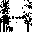

In [13]:
img1 = cv2.imread("lake.jpg")
img1 = cv2.resize(img1,(32,32))
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2RGB)
# img2 = cv2.imread("peppers.jpg")
# img2 = cv2.resize(img2,(32,32))
# img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
# img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
# img3 = cv2.imread("mandril.jpg")
# img3 = cv2.resize(img3,(32,32))
# img3 = cv2.cvtColor(img3,cv2.COLOR_BGR2GRAY)
# img3 = cv2.cvtColor(img3,cv2.COLOR_GRAY2BGR)
ret1, thresh1 = cv2.threshold(img1,70,255,0)
gray1 = cv2.cvtColor(thresh1, cv2.COLOR_BGR2GRAY)
#gray1 = thresh1
conv_im_11 = conv_img_01(gray1)
# ret2, thresh2 = cv2.threshold(img2,70,255,0)
# gray2 = cv2.cvtColor(thresh2, cv2.COLOR_BGR2GRAY)
# #gray2 = thresh2
# conv_im_12 = conv_img_01(gray2)
# ret3, thresh3 = cv2.threshold(img3,70,255,0)
# gray3 = cv2.cvtColor(thresh3, cv2.COLOR_BGR2GRAY)
# #gray3 = thresh3
# conv_im_13 = conv_img_01(gray3)
cv2_imshow(thresh1)
# cv2_imshow(thresh2)
# cv2_imshow(thresh3)

# Convert the above intermediate superposition images to binary
This code block defines a function `conv_im_bin` that binarizes an image by setting pixel values greater than 0 to 255 and values equal to 0 to 0. It then applies this function to the converted images (`conv_im_11`, `conv_im_12`, `conv_im_13`) generated in the previous step and displays the binarized images.

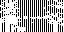

In [14]:
### Superposition state
def conv_im_bin(conv_im):
  for i in range(0,len(conv_im)) :
    for j in range(0,len(conv_im[0])):
      if conv_im[i][j] >0:
        conv_im [i][j] = 255
      else:
        conv_im [i][j] = 0
  return conv_im
# conv_im_1 = conv_im_bin(conv_im)
# cv2_imshow(conv_im_1)
conv_im_11 = conv_im_bin(conv_im_11)
cv2_imshow(conv_im_11)
# #cv2.imwrite(lake_sup.png, conv_im_11)
# conv_im_12 = conv_im_bin(conv_im_12)
# cv2_imshow(conv_im_12)
# #cv2.imwrite(peper_sup.png, conv_im_12)
# cv2_imshow(conv_im_13)
# #cv2.imwrite(mandril-sup.png, conv_im_13)

This code block contains commented-out code for converting a grayscale image using `conv_img6` and displaying the result.

In [15]:
#print(gray.shape)
#bw_rand= conv_img6(gray)
#cv2_imshow(bw_rand)

# Define function to perform multiple measurements and average out

This code block defines several functions (`convshots`, `convshots6`, `convshots7`) that apply image conversion functions (`conv1_rgb`, `conv_img6`, `conv7_rgb` respectively) multiple times (controlled by the `shots` parameter) and then average the results to produce a final converted image. This simulates a process involving multiple measurements or trials

## Convshots7 is for binary based measurement
## Convshots applies on RGB image
## Convshots6 applies on single channel image

In [16]:
def convshots(img,shots=50):
    img_list=[]
    for i in range(shots):
        conv2 = conv1_rgb(img)
        img_list += [conv2]
    converted = np.zeros((256,256,3))
    sh = 0
    print(len(img),len(img[0]),len(img[0][0]))
    for i in range(0,len(img)):
         for j in range(0,len(img[0])):
             for k in range(0,len(img[0][0])):
                #val = {}
                val = 0
                for l in range(shots):
                    #print(i,j,k,l,img_list[l][i][j][k])
                    val += img_list[l][i][j][k]
                    '''
                    if img_list[l][i][j][k] in val:
                        val[img_list[l][i][j][k]]+=1
                    else:
                        val[img_list[l][i][j][k]]=1
                keys = list(val.keys())
                print(val)
                if(len(keys)>1):
                    if val[keys[0]]>val[keys[1]]:
                        converted[i][j][k] = keys[0]
                    else:
                        converted[i][j][k] = keys[1]
                else:
                    converted[i][j][k] = keys[0]
                    '''
                converted[i][j][k] = val/shots
                #print(sh)
                sh+=1
    return converted

def convshots6(img,shots=50):
    img_list=[]
    for i in range(shots):
        conv2 = conv_img6(img)
        img_list += [conv2]
    converted = np.zeros((256,256))
    sh = 0
    print(len(img),len(img[0]))
    for i in range(0,len(img)):
         for j in range(0,len(img[0])):
                #val = {}
                val = 0
                for l in range(shots):
                    #print(i,j,k,l,img_list[l][i][j][k])
                    val += img_list[l][i][j]
                    '''
                    if img_list[l][i][j][k] in val:
                        val[img_list[l][i][j][k]]+=1
                    else:
                        val[img_list[l][i][j][k]]=1
                keys = list(val.keys())
                print(val)
                if(len(keys)>1):
                    if val[keys[0]]>val[keys[1]]:
                        converted[i][j][k] = keys[0]
                    else:
                        converted[i][j][k] = keys[1]
                else:
                    converted[i][j][k] = keys[0]
                    '''
                converted[i][j] = val/shots
                #print(sh)
                sh+=1
    return converted


def convshots7(img, shots=1, img_size=256):
    img_list=[]
    for i in range(shots):
        conv2 = conv7_rgb(img, img_size)
        img_list += [conv2]
    converted = np.zeros((img_size,img_size,3))
    sh = 0
    print(len(img),len(img[0]))
    for i in range(0,len(img)):
         for j in range(0,len(img[0])):
           for k in range(0,len(img[0][0])):
                #val = {}
                val = 0
                for l in range(shots):
                    #print(i,j,k,l,img_list[l][i][j][k])
                    val += int(img_list[l][i][j][k])
                    '''
                    if img_list[l][i][j][k] in val:
                        val[img_list[l][i][j][k]]+=1
                    else:
                        val[img_list[l][i][j][k]]=1
                keys = list(val.keys())
                print(val)
                if(len(keys)>1):
                    if val[keys[0]]>val[keys[1]]:
                        converted[i][j][k] = keys[0]
                    else:
                        converted[i][j][k] = keys[1]
                else:
                    converted[i][j][k] = keys[0]
                    '''
                converted[i][j][k] = np.float64(val/shots)
                #print(sh)
                sh+=1
    return converted

## Redundant redefinition of convshots

This code block redefines the `convshots` function, likely to correct or modify the previous definition. This version also applies `conv1_rgb` multiple times and averages the results.

In [17]:
def convshots(img,shots=1):
    img_list=[]
    for i in range(shots):
        conv2 = conv1_rgb(img)
        img_list += [conv2]
    converted = np.zeros((256,256,3))
    sh = 0
    print(len(img),len(img[0]),len(img[0][0]))
    for i in range(0,len(img)):
         for j in range(0,len(img[0])):
             for k in range(0,len(img[0][0])):
                #val = {}
                val = 0
                for l in range(shots):
                    #print(i,j,k,l,img_list[l][i][j][k])
                    val += img_list[l][i][j][k]
                    '''
                    if img_list[l][i][j][k] in val:
                        val[img_list[l][i][j][k]]+=1
                    else:
                        val[img_list[l][i][j][k]]=1
                keys = list(val.keys())
                print(val)
                if(len(keys)>1):
                    if val[keys[0]]>val[keys[1]]:
                        converted[i][j][k] = keys[0]
                    else:
                        converted[i][j][k] = keys[1]
                else:
                    converted[i][j][k] = keys[0]
                    '''
                converted[i][j][k] = val/shots
                #print(sh)
                sh+=1
    return converted

# Apply Convshots7
This code block loads the `lake.jpg` image, resizes it to 256x256, and then applies the `convshots7` function with the default number of shots (1) to it, storing the result in `n_img`.

In [18]:
img1 = cv2.imread("lake.jpg")
img1 = cv2.resize(img1,(256,256))
n_img = convshots7(img1, img_size=256)

256 256


# View Image after 1shot measurement using convshot7
This code block displays the image stored in the `n_img` variable, which is the result of applying the `convshots7` function to the `lake.jpg` image.

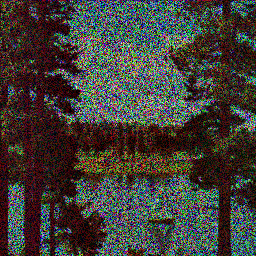

In [19]:
cv2_imshow(n_img)

This code block contains commented-out code to apply the `convshots` function to the `n_img` and store the result in `n_n_img`.

In [20]:
#n_n_img = convshots(n_img)

This code block contains commented-out code to display the image stored in the `n_n_img` variable.

In [21]:
#cv2_imshow(n_n_img)

This code block contains commented-out code to print the pixel value at the first position (0,0) of the `n_n_img`.

In [22]:
#print(n_n_img[0][0])

This code block lists all files in the current directory and prints their names.

In [23]:
files = [f for f in os.listdir(".") if os.path.isfile(f)]
print(files)

['lake.jpg']


# Run convshots7 on all three images and get image analysis result
This code block iterates through the files in the current directory, loads each image, resizes it, and applies the `convshots7` function with a varying number of shots (1 and 10). It then displays the converted image, saves it to a file, and calculates various image quality metrics (MSE, RMSE, PSNR, SSIM, UQI, MSSSIM, ERGAS, SCC, RASE, SAM) by comparing the restored image with the original. These metrics and the filename are stored in a pandas DataFrame. The code block was interrupted during execution.

lake.jpg
Real Image 32 1:


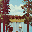

32 32
Converted Image 32 1:


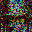

Real Image 32 10:


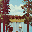

32 32
Converted Image 32 10:


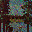

Real Image 32 100:


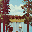

32 32
Converted Image 32 100:


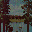

Real Image 32 1000:


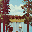

32 32
Converted Image 32 1000:


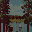

Real Image 64 1:


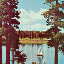

64 64
Converted Image 64 1:


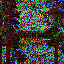

Real Image 64 10:


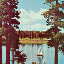

64 64
Converted Image 64 10:


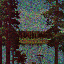

Real Image 64 100:


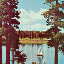

64 64
Converted Image 64 100:


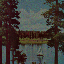

Real Image 64 1000:


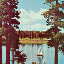

64 64
Converted Image 64 1000:


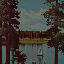

Real Image 128 1:


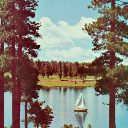

128 128
Converted Image 128 1:


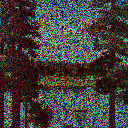

Real Image 128 10:


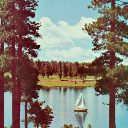

128 128
Converted Image 128 10:


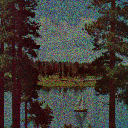

Real Image 128 100:


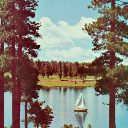

128 128
Converted Image 128 100:


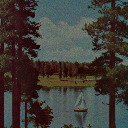

Real Image 128 1000:


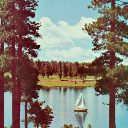

128 128
Converted Image 128 1000:


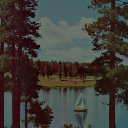

Real Image 256 1:


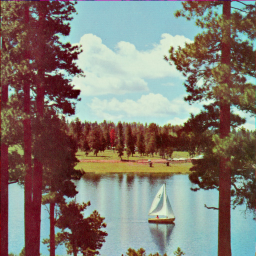

256 256
Converted Image 256 1:


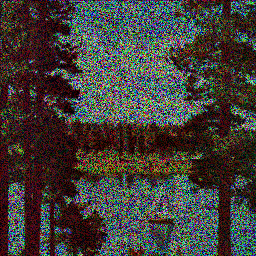

Real Image 256 10:


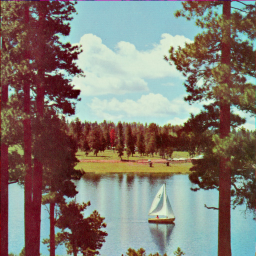

256 256
Converted Image 256 10:


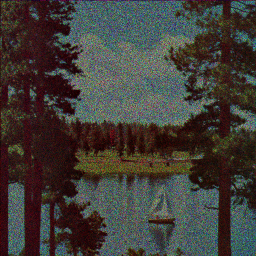

Real Image 256 100:


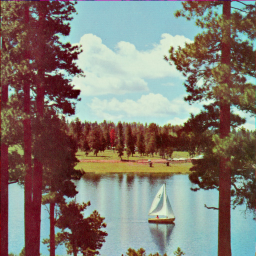

256 256
Converted Image 256 100:


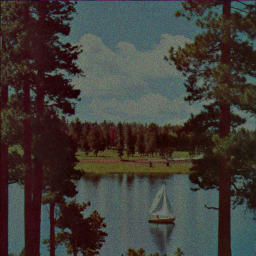

Real Image 256 1000:


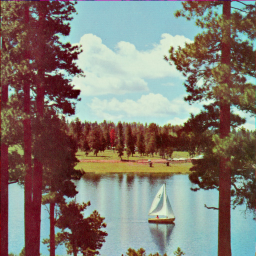

KeyboardInterrupt: 

In [24]:
df = pd.DataFrame()
for filey in files:
    print(filey)
    for img_size in (32, 64, 128, 256):
      #for k in (1,100,1000):
      for k in (1, 10, 100,1000):
          img = cv2.imread(filey)
          small = cv2.resize(img,(img_size,img_size))
          #small = cv2.cvtColor(small, cv2.COLOR_BGRA2GRAY)
          #small = cv2.cvtColor(small, cv2.COLOR_BGR2RGB)
          #plt.imsave(filey.split(".")[0]+"_real.jpg",small)
          # cv2.imwrite(filey.split(".")[0]+"_real.jpg",small)
          #real = cv2.imread(filey.split(".")[0]+"_real.jpg")
          real = small
          print(f"Real Image {img_size} {k}:")
          cv2_imshow(real)
          start = datetime.datetime.now()
          conv = convshots7(real,k, img_size)
          end = datetime.datetime.now()
          #conv = cv2.cvtColor(conv, cv2.COLOR_BGR2RGB)
          print(f"Converted Image {img_size} {k}:")
          cv2_imshow(conv)
          #plt.imsave(filey.split(".")[0]+"_conv.jpg", conv)
          cv2.imwrite(filey.split(".")[0]+str(k)+f"_conv_a_{img_size}.jpg",conv)
          restored = cv2.imread(filey.split(".")[0]+str(k)+f"_conv_a_{img_size}.jpg")
          values = {
              "Name": filey,
              "size": img_size,
              "shots": k,
              "time": (end-start).total_seconds(),
              "MSE": np.round(mse(restored,real),3),
              "RMSE": np.round(rmse(restored, real),3),
              "PSNR": np.round(psnr(restored, real),3),
              "SSIM": (np.round(ssim(restored, real)[0],3),np.round(ssim(restored, real)[1],3)),
              "UQI": np.round(uqi(restored, real),3),
              "MSSSIM": np.round(msssim(restored, real).real,3),
              "ERGAS": np.round(ergas(restored, real),3),
              "SCC": np.round(scc(restored, real),3),
              "RASE": np.round(rase(restored, real),3),
              "SAM": np.round(sam(restored, real),3)
          }
          df = pd.concat([df,pd.DataFrame.from_dict([values])])

This code block displays the head of the DataFrame `df`, showing the first few rows of the collected image quality metrics.

In [25]:
df.head()

,Name,size,shots,time,MSE,RMSE,PSNR,SSIM,UQI,MSSSIM,ERGAS,SCC,RASE,SAM
0,lake.jpg,32,1,0.376284,6158.491,78.476,10.236,"(0.459, 0.573)",0.607,0.736,31.942,0.455,7906.036,0.471
0,lake.jpg,32,10,3.258695,5140.679,71.699,11.021,"(0.6, 0.751)",0.632,0.802,29.294,0.778,7267.469,0.191
0,lake.jpg,32,100,36.129060,5008.074,70.768,11.134,"(0.631, 0.789)",0.636,0.805,28.909,0.904,7150.631,0.111
0,lake.jpg,32,1000,336.862879,5011.567,70.792,11.131,"(0.636, 0.795)",0.637,0.806,28.974,0.932,7142.517,0.100
0,lake.jpg,64,1,1.226319,6380.051,79.875,10.083,"(0.402, 0.499)",0.604,0.690,32.603,0.375,7941.267,0.485


This code block transposes the DataFrame `df`, swapping rows and columns.

In [26]:
df = df.transpose()

This code block saves the transposed DataFrame `df` to a CSV file named 'Original-Restored Comparison.csv'.

In [27]:
df.to_csv('Original-Restored Comparison.csv')

This code block reads the CSV file 'Original-Restored Comparison.csv' into a new pandas DataFrame named `df1`.

In [28]:
df1 = pd.read_csv("Original-Restored Comparison.csv")

This code block displays the first 11 rows of the DataFrame `df1`.

In [29]:
df1.head(13)

,Unnamed: 0,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,0.11,0.12,0.13,0.14
0,Name,lake.jpg,lake.jpg,lake.jpg,lake.jpg,lake.jpg,lake.jpg,lake.jpg,lake.jpg,lake.jpg,lake.jpg,lake.jpg,lake.jpg,lake.jpg,lake.jpg,lake.jpg
1,size,32,32,32,32,64,64,64,64,128,128,128,128,256,256,256
2,shots,1,10,100,1000,1,10,100,1000,1,10,100,1000,1,10,100
3,time,0.376284,3.258695,36.12906,336.862879,1.226319,13.125295,131.599362,1360.028329,6.005112,53.530301,542.310458,5457.958342,21.100014,214.864226,2188.668147
4,MSE,6158.491,5140.679,5008.074,5011.567,6380.051,5128.87,5037.819,5018.223,6303.727,5136.144,5019.672,5008.106,6229.175,5109.398,4984.682
5,RMSE,78.476,71.699,70.768,70.792,79.875,71.616,70.978,70.839,79.396,71.667,70.85,70.768,78.925,71.48,70.602
6,PSNR,10.236,11.021,11.134,11.131,10.083,11.031,11.108,11.125,10.135,11.024,11.124,11.134,10.186,11.047,11.154
7,SSIM,"(np.float64(0.459), np.float64(0.573))","(np.float64(0.6), np.float64(0.751))","(np.float64(0.631), np.float64(0.789))","(np.float64(0.636), np.float64(0.795))","(np.float64(0.402), np.float64(0.499))","(np.float64(0.571), np.float64(0.713))","(np.float64(0.627), np.float64(0.783))","(np.float64(0.638), np.float64(0.798))","(np.float64(0.344), np.float64(0.428))","(np.float64(0.531), np.float64(0.663))","(np.float64(0.622), np.float64(0.777))","(np.float64(0.647), np.float64(0.809))","(np.float64(0.287), np.float64(0.355))","(np.float64(0.486), np.float64(0.607))","(np.float64(0.614), np.float64(0.768))"
8,UQI,0.607,0.632,0.636,0.637,0.604,0.634,0.636,0.636,0.604,0.634,0.637,0.637,0.608,0.633,0.637
9,MSSSIM,0.736,0.802,0.805,0.806,0.69,0.768,0.78,0.783,0.659,0.753,0.784,0.79,0.625,0.749,0.797
